### Temporally Correlated Active Noise Simulation Tutorial

#### Introduction

This tutorial is aimed at introducing nonequilibrium activity to OpenMiChroM simulations. First, we will go through a very brief introduction of the theoretical idea, then, the simulation procedures are discussed.

##### Theory

Activity, such as originating from molecular motors applying forces on the polymer, is modeled as 
an athermal drive experienced by each coarse-grained monomer. Since motors typically exhibit on/off dynamics, the athermal force is expected to be correlated in time, as opposed to the thermal noise
that is temporally uncorrelated. To model activity, we add a novel noise-like term to the forces associated with a monomer, such that the equation of motion of the $n$-th monomer reads as follows:

$$
\gamma \frac{dr_n}{dt} = -\nabla_n U + \xi^{\rm therm}_n + f^{\rm act}_n
$$

where $\gamma$ is the damping coefficient and $U$ is the passive potential, like the harmonic bonds joining neighboring monomers in a polymer. 
$\xi^{\rm therm}_n$ is the the thermal noise that is uncorrelated over time as well as across the chain:

$$
\langle \xi^{\rm therm}_n(t)\rangle=0\quad \text{and} \quad \langle \xi^{\rm therm}_n(t)\xi^{\rm therm}_m(t^\prime)\rangle = 2\gamma T\delta_{mn}\delta(t-t^\prime).
$$

The active noise kicks are given by $f^{\rm act}(t)$, which are correlated over time and their correlation decays over a characteristic time scale $\tau$:

$$
\langle f^{\rm act}_n  \rangle=0 \quad \text{and} \quad \langle f^{\rm act}_n(t)f^{\rm act}_m(t^\prime)  \rangle=F^2e^{-|t-t^\prime|/\tau}\delta_{mn}
$$

The dynamics of the active force of the $n$-th monomer is governed by the following equation:

$$
\tau \frac{df^{\rm act}_n}{dt} = -f^{\rm act}_n + \sqrt{2\gamma \theta_a}\eta(t)
$$

where $\theta_a\equiv F^2\tau/\gamma$ is the active temperature-like quantity, and $\eta(t)$ is a delta-correlated stationary Gaussian process.


##### Brownian Dynamics
Brownian dynamics only has forces and displacements, and no velocities. The positions after time $\Delta t$, given by $x(t+\Delta t)$ are computed based on the current forces $h(t)$ and positions $x(t)$.

$$
x_n(t+\Delta t)=x_n(t)+\frac{h_n(t)}{\gamma}\Delta t+\sqrt{\frac{2T}{\gamma}\Delta t}\mathcal{N}(0,1)
$$

where the last term is the thermal kick at temperature $T$ with $\mathcal{N}(0,1)$ representing a random Normal variable with zero mean and unit standard deviation. The net force experienced by the $n$-th monomer at time step $t$ is given by $h_n(t)$.

$$
h_n(t)= -\frac{\partial}{\partial x}\sum_{m}U(|x_n(t)-x_m(t)|)+f^{\rm act}_n(t)
$$

The net force for a monomer $h(t)$, depends on the active force of the monomer $f^{\rm act}(t)$, which is related to the active force in the previous time step $f^{\rm act}(t-\Delta t)$.
The active force on the $n$-th monomer at time $t$ is obtained as follows:

$$
f^{\rm act}_n(t)=f^{\rm act}_n(t-\Delta t)e^{-\Delta t/\tau}+{F}\sqrt{1-e^{-2\Delta t/\tau}}\mathcal{\tilde{N}}(0,1)
$$


where $\mathcal{\tilde{N}}(0,1)$ is  a random Normal variable that is different from the thermal one. 

Next is a step-by-step guidance on how to setup and run OpenMiChroM simulations with correlated active noise. Users not familiar with running OpenMiChroM simulations, would greatly benefit from first going through the practice of running equilibrium OpenMiChroM simulations (see https://open-michrom.readthedocs.io/en/latest/Tutorials/Tutorial_Single_Chromosome.html). For users already familiar with OpenMiChroM, it is still the same simulation object that is created and basic steps of running the simulations are the same. The main differences are two fold: 
1. Adding activity using a function **addCorrelatedNoise()**. One should make sure to add activity as the first force field. It is extremely important that the active force is assigned a force-group "0".
2. Using a custom integrator **ActiveBrownianIntegrator** (see Integrator.py) that takes care of the active force which is hard-coded to be the force-group "0". Hence the catutionary statement above.

Hope you follow along!

#### Simulations
##### Import modules

Active functions are 


In [ ]:
import sys 
sys.path.append(r'C:\Users\Wangleren\Documents\GitHub\OpenMiChroM\OpenMiChroM')# my path
from OpenMiChroM.ChromDynamics import MiChroM # usually if not note "OpenMichroM.", error happens
from OpenMiChroM.Integrators import ActiveBrownianIntegrator
import numpy as np

##### Initialize simulation

In [10]:
# Instantiate MiChroM object
sim = MiChroM(name='active_Rouse_sim', temperature=0.2, time_step=0.001, collision_rate=1.0)

# specify platform and output destination
sim.setup(platform="cuda")
sim.saveFolder('./out')
active_correaltion_time = 5.0
#specify the integrator for correlated noise
#note that the force-group "0" is associated with the correlated active noise
sim.integrator = ActiveBrownianIntegrator(timestep=sim.timestep, temperature=sim.temperature, 
                                        collision_rate=sim.collisionRate, corr_time=active_correaltion_time)

    ***************************************************************************************     
     **** **** *** *** *** *** *** *** OpenMiChroM-1.0.7 *** *** *** *** *** *** **** ****      

         OpenMiChroM is a Python library for performing chromatin dynamics simulations.         
                            OpenMiChroM uses the OpenMM Python API,                             
                employing the MiChroM (Minimal Chromatin Model) energy function.                
      The chromatin dynamics simulations generate an ensemble of 3D chromosomal structures      
      that are consistent with experimental Hi-C maps, also allows simulations of a single      
                 or multiple chromosome chain using High-Performance Computing                  
                            in different platforms (GPUs and CPUs).                             
         OpenMiChroM documentation is available at https://open-michrom.readthedocs.io          

         OpenMiChroM is desc

##### Load initial structure

In [11]:
# generate a test sequence file of size n
n=10
with open('test_seq.txt','w') as seq_file:
    for ii in range(n):
        seq_file.write(f'{ii+1} A1\n')

# create a random configuration with the sequence file
init_struct = sim.createRandomWalk(ChromSeq='test_seq.txt')
sim.loadStructure(init_struct, center=True)

#uncomment below to save the loaded structure
#  sim.saveStructure(mode = 'auto')

##### Add forces

In [13]:
# For the purpose of the simualtion we will consider a simple simulation of an active Rouse chain - harmonically bonded monomers with zero rest length
# the good things about active Rouse chain is that the dynamics may be calculated analytically and compared for verification.
# Any force-field available for OpenMiChroM, like self-avoidance, may be used. 
# However, since Brownian Dynamics does not have momentum, it is prudent to make sure the time step is small enough for steep potentials. 
# Using too large a time step with steep (or worse, diverging!) potentials will generate huge forces, possibly leading to explosion! wear your safety goggles!

# Now the force-fields:
# first, add correlated noise. 
# IMPORTANT: correlated noise should always be added as the *first* force-field.
# This is because force-group "0" is hard-coded as the active force within ActiveBrownianIntegrator
# act_seq contains the active force values F for each monomer. It needs to be the same size as the total number of monomers
# the values F_i in the list need not be the same, they can be heterogenous depicting varied motor activity
# below we consider a homogenously active polymer
F = 0.5
sim.addCorrelatedNoise(act_seq=F*np.ones(sim.N))

# add Harmonic bonds between monomers of the chain. Use sim.chains to get the number of chains.
# setting the rest length to zero since the analytical form is easier to calculate that way.
kb=5.0
sim.addHarmonicBonds(kfb=kb, r0=0.0)

# adding soft-core self-avoidance 
# repulsion is modeled using a sigmoid function with a finite overlap energy Ecut
# sim.addSelfAvoidance(Ecut=4.0, k_rep=20.0, r0=1.0)

# half-harmonic restraint as confinement
# sim.addFlatBottomHarmonic(kr=10.0, n_rad=20.0)


            Active Monomers (correlated noise) added.
            Active correlation time: 5.0
            Total number of active monomers: 10
            Total number of monomers: 10



##### Run intial collapse

In [14]:
#run collapse simulation
for _ in range(10):
    sim.runSimBlock(3000, increment=False)

# save the collapsed structure -- uncomment below
# sim.saveStructure(filename='collapse',mode='ndb')

bl=97 pos[1]=[-6.8 1.8 6.2] dr=2.11 t=99.6ps kin=0.00 pot=0.00 Rg=11.028 SPS=6492 
bl=97 pos[1]=[-9.1 0.2 6.5] dr=1.75 t=102.6ps kin=0.00 pot=0.00 Rg=11.248 SPS=7555 
bl=97 pos[1]=[-9.5 1.4 7.5] dr=1.89 t=105.6ps kin=0.00 pot=0.00 Rg=10.965 SPS=8980 
bl=97 pos[1]=[-9.7 1.2 6.7] dr=2.07 t=108.6ps kin=0.00 pot=0.00 Rg=10.887 SPS=8920 
bl=97 pos[1]=[-11.2 1.3 9.0] dr=1.97 t=111.6ps kin=0.00 pot=0.00 Rg=11.371 SPS=8668 
bl=97 pos[1]=[-11.6 2.0 8.3] dr=2.37 t=114.6ps kin=0.00 pot=0.00 Rg=11.446 SPS=9144 
bl=97 pos[1]=[-11.2 2.8 10.2] dr=2.01 t=117.6ps kin=0.00 pot=0.00 Rg=11.399 SPS=8900 
bl=97 pos[1]=[-9.9 2.5 11.4] dr=1.84 t=120.6ps kin=0.00 pot=0.00 Rg=11.557 SPS=8980 
bl=97 pos[1]=[-8.8 4.2 14.0] dr=2.19 t=123.6ps kin=0.00 pot=0.00 Rg=12.488 SPS=8668 
bl=97 pos[1]=[-6.5 2.2 13.5] dr=1.97 t=126.6ps kin=0.00 pot=0.00 Rg=11.923 SPS=7750 


##### Run simulation

In [15]:
# For the purpose of the tutorial we will just store the data in the xyz array for plotting
# you may instead save the data into cndb/ndb/pdb files and load into numpy arrays using cndbtools
# if you would like to save the data uncomment the lines below

# sim.initStorage(filename="active_Rouse_sim"") # initiate storage

xyz = [sim.getPositions()]

n_blocks = 500 # number of simulation blocks
block_size = 1000 # size of each block

for _ in range(int(n_blocks)):
    sim.runSimBlock(int(block_size), increment=True)
    # sim.saveStructure()
    xyz.append(sim.getPositions())
    
# sim.saveStructure(filename='lastframe',mode='ndb')
# sim.storage[0].close()

xyz = np.array(xyz)
print(xyz.shape) # the shape should be: (number of blocks, number of monos, deg. of freedom)


bl=98 pos[1]=[-7.1 2.2 14.0] dr=1.00 t=127.6ps kin=0.00 pot=0.00 Rg=12.064 SPS=8614 
bl=99 pos[1]=[-6.0 1.8 13.9] dr=1.06 t=128.6ps kin=0.00 pot=0.00 Rg=11.785 SPS=8694 

Statistics for the simulation active_Rouse_sim, number of particles: 10,  number of chains: 1

Statistics for particle position
     mean position is:  [ 1.05296987 -2.031958   -2.77470717]   Rg =  11.784524
     median bond size is  16.79213286686015
     three shortest/longest (<10)/ bonds are  [ 7.94738905  8.68232248 15.299746  ]    [7.94738905 8.68232248]
longest 10 bonds are [ 7.94738905  8.68232248 15.299746   15.52174339 16.79213287 17.87283198
 18.53808982 20.25314865 23.39992823]
     95 percentile of distance to center is:    16.997533064430407
     density of closest 95% monomers is:    0.0004618248650628122
     density of the core monomers is:    0.000283351736863625
     min/median/mean/max coordinates are: 
     x: -11.16, 3.14, 1.05, 8.15
     y: -8.07, -2.88, -2.03, 5.08
     z: -16.95, -5.33, -2.77,

##### Visualize trajectory

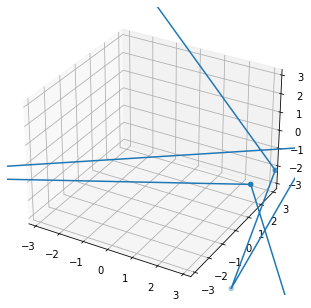

In [17]:
#import the libraries for plotting
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

# ipympl is necessary for dynamic plotting
# dynamic plotting is not supported inline
#%matplotlib ipympl

fig = plt.figure(1)
ax = fig.add_axes([0,0,1,1],projection='3d')

R0=sim.N**(0.5)

ax.scatter(xyz[0,:,0],xyz[0,:,1],xyz[0,:,2],'o',color='C0')
ax.plot(xyz[0,:,0],xyz[0,:,1],xyz[0,:,2],'-',color='C0')
ax.set_zlim(-R0, R0)
ax.set_xlim(-R0, R0)
ax.set_ylim(-R0, R0)

def update(ii):
    ax.cla()
    p=xyz[ii]
    ax.scatter(p[:,0],p[:,1],p[:,2],'o',color='C0')
    ax.plot(p[:,0],p[:,1],p[:,2],'-',color='C0')
    ax.set_zlim(-R0, R0)
    ax.set_xlim(-R0, R0)
    ax.set_ylim(-R0, R0)
    
anim = FuncAnimation(fig, update, frames=np.arange(1,400,1), interval=200, blit=False,repeat=False)

# uncomment below to save the animation
# anim.save('animation_active_sim.gif', writer='pillow')

plt.show()


##### Verify dynamics

In [18]:
from CndbTools import cndbTools
cndbT = cndbTools()

def active_gas_MSD(t_lag, temp, F, tau, g, d=3):
    return d*(2*temp*t_lag/g + (2*F**2*tau/g**2)*(t_lag + tau*np.exp(-t_lag/tau)) - 2*F**2*tau**2/g**2)

def tau_rouse(p,kb,N,g):
    return g*N**2/(np.pi**2*kb*p**2)

def active_Rouse_MSD(t_lag, temp, F, tau, kb, N, g, d=3):

    rouse_modes=np.arange(1, N+1, 1)
    tau_mode_i=tau_rouse(rouse_modes, kb, N, g)
    val=(tau_mode_i*(temp+F**2*tau*tau_mode_i**2/(g*(tau_mode_i**2-tau**2)))*(1-np.exp(-t_lag/tau_mode_i))/(2*N*g)
        -(F*tau*tau_mode_i)**2*(1-np.exp(-t_lag/tau))/(2*N*g**2*(tau_mode_i**2-tau**2)))*0.5
    # print(val.shape)
    
    return (2*d*(temp+F**2*tau/g)*t_lag/(N*g) - 2*d*F**2*tau**2*(1-np.exp(-t_lag/tau))/(N*g**2) + 8*d*np.sum(val))
    

In [19]:
# compute_MSD returns an (N * T) array with mononers in the first dimension and lag time in the second
msd_rouse = np.mean(cndbT.compute_MSD(xyz), axis=0)

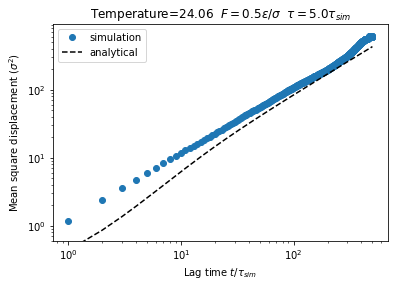

In [20]:
#%matplotlib inline

#lag times
ts = np.arange(0,xyz.shape[0], block_size*0.001)

plt.loglog(ts, msd_rouse,'o', label='simulation')
plt.loglog(ts, [active_Rouse_MSD(xx, sim.temperature*0.008314, F, sim.integrator.corrTime, kb, sim.N, 1.0) for xx in ts],'k--', label='analytical')
plt.legend()
plt.ylabel('Mean square displacement ($\\sigma^2$)')
plt.xlabel('Lag time $t/\\tau_{sim}$')
plt.title('Temperature={0:.2f}  $F={1:.1f}\\epsilon/\\sigma$  $\\tau={2:.1f} \\tau_{{sim}}$'.format(sim.temperature,F, sim.integrator.corrTime))
plt.ylim(msd_rouse[1]*0.5,max(msd_rouse)*1.5)
plt.show()